In [71]:
from astropy.io import fits
import pylab as plt
import numpy as np
from scipy.optimize import curve_fit

plt.style.use('seaborn-whitegrid')

In [83]:
plt.rc('text', usetex=False)

In [80]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

In [81]:
plt.rc('font', **font)

In [30]:
#plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [50]:
def frequency(data):
    nu_samp = 96e6
    
    freq = np.fft.fftfreq(len(data), d = 1/nu_samp)
    return freq

In [2]:
hdu1 = fits.open('noise_off.fits')

In [84]:
data1 = hdu1[1].data['auto0_real']

In [5]:
hdu2 = fits.open('noise_on.fits')

In [6]:
data2 =  hdu2[1].data['auto0_real']

In [94]:
cal_avg = average_spectrum(hdu2)
cold_avg = average_spectrum(hdu1)

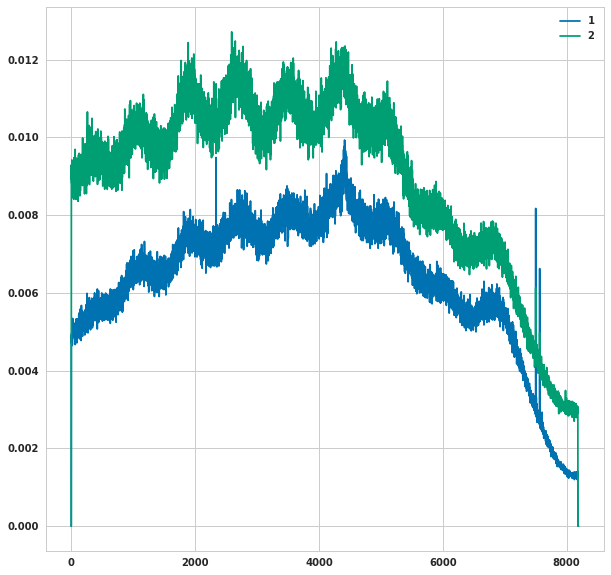

In [90]:
plt.figure(figsize = (10,10))
plt.plot(data1, label = '1')
plt.plot(data2, label = '2')
plt.legend()

In [10]:
hdu_cass = fits.open('cassiopea.fits')

In [41]:
hdr_cass = hdu_cass[0].header

In [42]:
print(repr(hdr_cass))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                  100 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [16]:
data_cass100 = hdu_cass[100].data['auto0_real']
data_cass1 = hdu_cass[1].data['auto0_real']

In [18]:
def average_spectrum(hdu):
    
    N = 1
    data = 0
    data_pol = 0
    
    while N <= 100:
        data += hdu[N].data['auto0_real']
        data_pol += hdu[N].data['auto1_real']
        N+=1
    
    avg = data/100
    avg_pol = data_pol/100
    return avg

In [19]:
avg_spec = average_spectrum(hdu_cass)

/Users/oscarachavezortiz/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


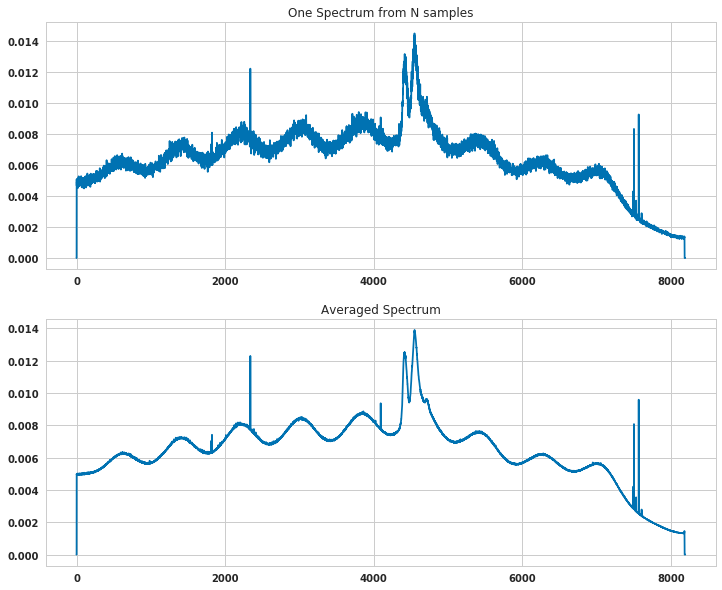

In [86]:
fig = plt.figure(figsize = (12,10))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_title('One Spectrum from N samples')
ax1.plot(data_cass1)

ax2.set_title('Averaged Spectrum')
ax2.plot(avg_spec)

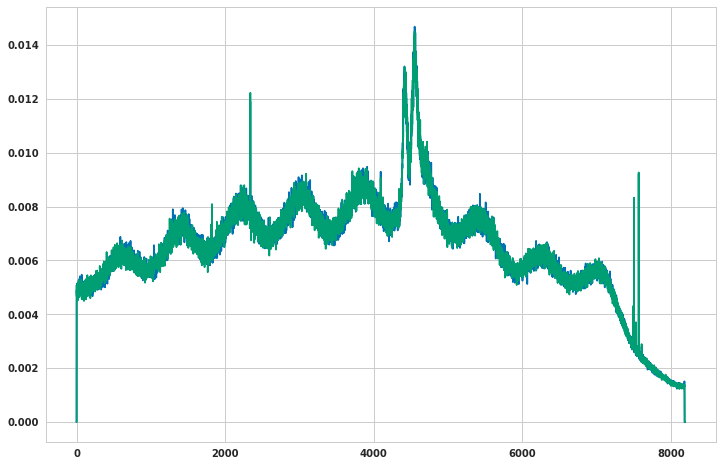

In [87]:
plt.figure(figsize = (12,8))
plt.plot(data_cass100)
plt.plot(data_cass1)

In [43]:
hdu_center = fits.open('cassiopea1.fits')

In [44]:
avg_center = average_spectrum(hdu_center)

In [51]:
freq = frequency(avg_center)

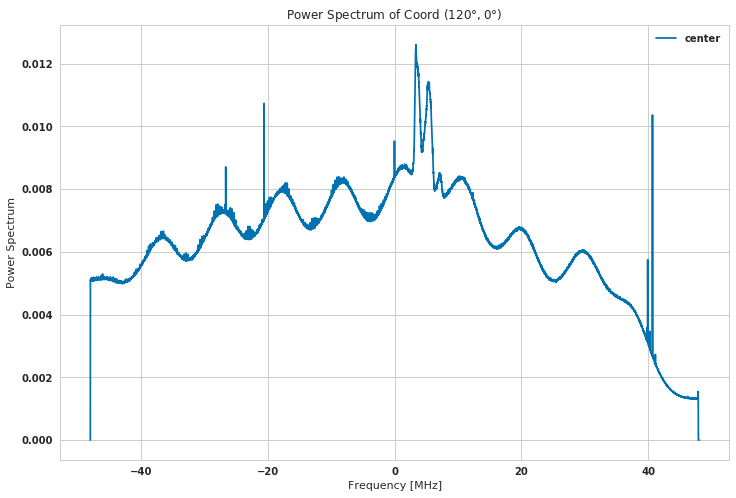

In [88]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fftshift(freq)/1e6, avg_center, label = 'center')
#plt.plot(np.fft.fftshift(freq)/1e6, base_data, label = 'base')

#plt.plot(avg_spec, label = 'cass')
plt.title(r'Power Spectrum of Coord ($120\degree, 0\degree$)')
plt.ylabel('Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.legend()

In [57]:
hdu_base = fits.open('cassiopea2.fits')

In [58]:
base_data = average_spectrum(hdu_base)

(0, 0.015)

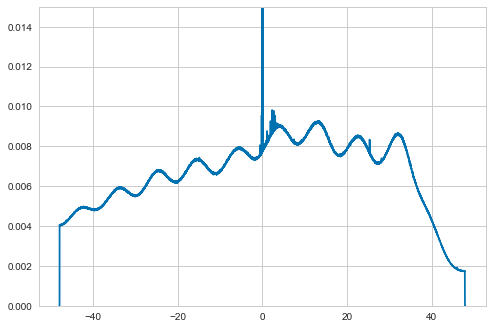

In [62]:
plt.plot(np.fft.fftshift(freq)/1e6, base_data)
plt.ylim(0,.015)

In [72]:
def fit(data, freq):
    
    def model(x, a, b, c):
        return a*x**2 + b*x + c
    
    param, covar = curve_fit(model, np.fft.fftshift(freq), data)
    
    return model(np.fft.fftshift(freq), param[0], param[1], param[2])


    

In [73]:
fitline = fit(avg_center, freq)

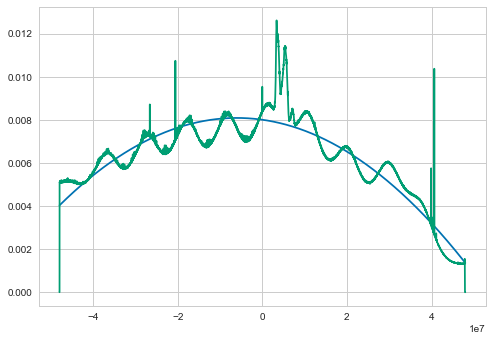

In [74]:
plt.plot(np.fft.fftshift(freq), fitline)
plt.plot(np.fft.fftshift(freq), avg_center)

In [75]:
diff = avg_center - fitline

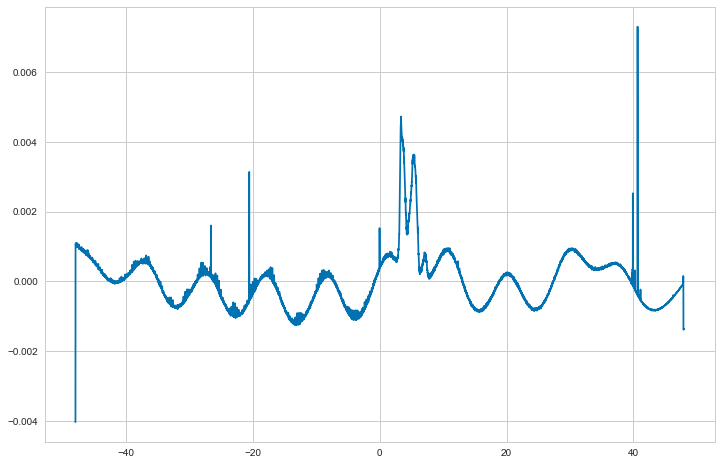

In [78]:
plt.figure(figsize = (12, 8))
plt.plot(np.fft.fftshift(freq)/1e6, diff)

In [97]:
def Gain(s_cal, s_cold):

    T_cal = 30
    T_cold = 2.73

    diff = s_cal-s_cold

    G = ((T_cal - T_cold)/(np.sum(diff))) * np.sum(s_cold)
    
    return G

In [98]:
G = Gain(cal_avg, cold_avg)

In [99]:
print(G)

65.23311626046477


In [100]:
def T_power(line, G):

    power = line * G

    return power

In [101]:
power = T_power(diff, G)

Text(0, 0.5, 'Temperature [K]')

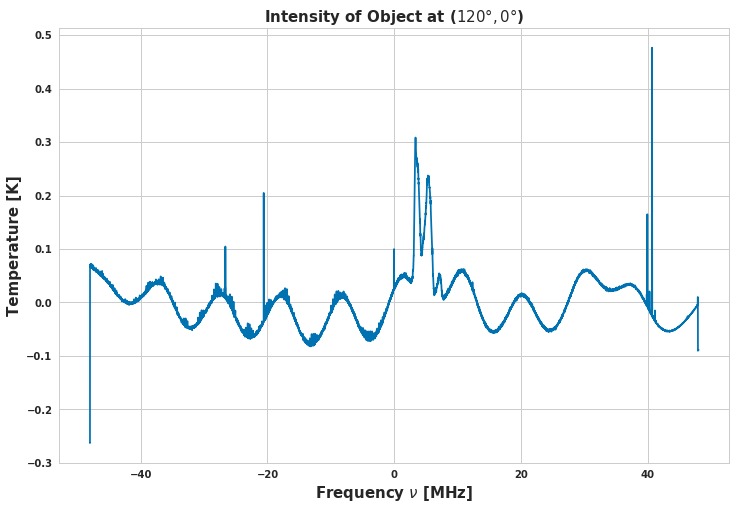

In [110]:
plt.figure(figsize = (12,8))
plt.title(r'Intensity of Object at ($120\degree, 0\degree$)', fontsize = 15, weight = 'semibold')
plt.plot(np.fft.fftshift(freq)/1e6, power)
plt.xlabel(r'Frequency $\nu$ [MHz]', fontsize = 15, weight = 'semibold')
plt.ylabel('Temperature [K]', fontsize = 15, weight = 'semibold')
